## 『本次練習內容』
#### 運用這幾天所學觀念搭建一個CNN分類器

## 『本次練習目的』
  #### 熟悉CNN分類器搭建步驟與原理
  #### 學員們可以嘗試不同搭法，如使用不同的Maxpooling層，用GlobalAveragePooling取代Flatten等等

In [102]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.datasets import cifar10
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras import regularizers

In [103]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # x是圖片,y是答案label

print(x_train.shape) #(50000, 32, 32, 3)

## Normalize Data
def normalize(X_train,X_test):
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7) 
        return X_train, X_test,mean,std
    
    
## Normalize Training and Testset    
x_train, x_test,mean_train,std_train = normalize(x_train, x_test) 

(50000, 32, 32, 3)


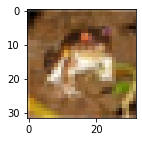

[6]


In [85]:
#Cifar-10 的所有圖片被分為 10 個類別 (以 0~9 數字作為 Label 之編碼) :
#0 : airplain (飛機)
#1 : automobile (汽車)
#2 : bird (鳥)
#3 : cat (貓)
#4 : deer (鹿)
#5 : dog (狗)
#6 : frog (青蛙)
#7 : horse (馬)
#8 : ship (船)
#9 : truck (卡車)
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # x是圖片,y是答案label
import matplotlib.pyplot as plt

def plot_image(image):
    fig=plt.gcf()
    fig.set_size_inches(2, 2)                          
    plt.imshow(image, cmap='binary')
    plt.show()

plot_image(x_train[0])
print(y_train[0]) 

In [104]:
## OneHot Label 由(None, 1)-(None, 10)
## ex. label=2,變成[0,0,1,0,0,0,0,0,0,0]
one_hot=OneHotEncoder()
y_train=one_hot.fit_transform(y_train).toarray()
y_test=one_hot.transform(y_test).toarray()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [106]:
classifier=Sequential()

#卷積組合
classifier.add(Convolution2D(32,(3,3),input_shape=(32,32,3),activation='relu'))
classifier.add(BatchNormalization())##BatchNormalization
classifier.add(MaxPooling2D(pool_size=(2,2)))

#卷積組合
classifier.add(Convolution2D(32,(3,3),activation='relu'))
classifier.add(BatchNormalization())##BatchNormalization
classifier.add(MaxPooling2D(pool_size=(2,2)))

#flatten
classifier.add(Flatten())

#FC
classifier.add(Dense(units=100,activation='relu',kernel_regularizer=regularizers.l2(l=0.001))) ##regularizers
classifier.add(BatchNormalization()) ##BatchNormalization
classifier.add(Dropout(rate=0.5)) ##Dropout

classifier.add(Dense(units=100,activation='relu',kernel_regularizer=regularizers.l2(0.001)))##regularizers
classifier.add(BatchNormalization()) ##BatchNormalization

classifier.add(Dropout(rate=0.3))##Dropout

classifier.add(Dense(units=10,activation='softmax'))
#超過兩個就要選categorical_crossentrophy
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

from keras.preprocessing.image import ImageDataGenerator ##Augmentation
img_gen = ImageDataGenerator( featurewise_center=True,featurewise_std_normalization=True,rotation_range=10,width_shift_range=0.1,
                                            height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=False,dtype=np.float32)
img_gen.fit(x_train)

from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='test_loss', patience=8, verbose=1) ##earlystop

##開始訓練
classifier.fit_generator(img_gen.flow(x_train, y_train, batch_size=100) ,steps_per_epoch=500,
                               epochs=100, validation_data = (x_test, y_test),callbacks = [earlystop])


Epoch 1/100


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_32/convolution (defined at C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_32389]

Function call stack:
keras_scratch_graph


## 預測新圖片，輸入影像前處理要與訓練時相同
#### ((X-mean)/(std+1e-7) ):這裡的mean跟std是訓練集的
## 維度如下方示範

In [ ]:
input_example=(np.zeros(shape=(1,32,32,3))-mean_train)/(std_train+1e-7) 
classifier.predict(input_example)